# Medicare opioid and non-opioid prescriber datasets cleanup and town join

### Goals:

* Clean up the Medicare Part D datasets (both the opioid prescriber and general prescription datasets)
* Merge these datasets with the town names in the opioid overdose deaths dataset

### Outputs:

* /data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [3]:
# cms opioid prescriber data
opi_pres_13_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2013.csv")
opi_pres_14_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2014.csv")
opi_pres_15_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2015.csv")
opi_pres_16_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2016.csv")
opi_pres_17_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2017.csv")

In [4]:
# cms non-opioid prescriber data (big file - takes a while)
all_pres_17_raw = pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_17.txt", sep='\t')

In [28]:
# zipcode - town association attempts
## zipcode - town lists (copy paste from websites)
zip_town_raw = pd.read_csv('../../data/raw_data/shapefiles_and_geography_related/ma_town_zipcode_list.txt', sep="(", header=None)
zip_town_raw_alt = pd.read_csv('../../data/raw_data/shapefiles_and_geography_related/ma_town_zipcode_list_alt.txt', sep='\t')
## shapfile of ma postal zipcodes
ma_postzip_map = gpd.read_file('../../data/raw_data/shapefiles_and_geography_related/zipcodes_nt/ZIPCODES_NT_POLY.shp')
# compare zipcodes and town names to the overdose deaths dataset (351 towns)
ma_over_death = pd.read_csv("../../data/tidy_data/overdose_death_count_acs_merge.csv")

In [6]:
# easier column names for opi prescriber dfs
lwr_column_names =[x.lower().replace(' ', '_') for x in opi_pres_13_raw.columns]
raw_opi_dflist = [opi_pres_13_raw, opi_pres_14_raw, opi_pres_15_raw, opi_pres_16_raw, opi_pres_17_raw]
for x in raw_opi_dflist:
    x.columns = lwr_column_names

In [8]:
# number of rows in each file:
for x in raw_opi_dflist:
    print(x.shape)

(1049299, 11)
(1072978, 11)
(1102253, 11)
(1131550, 11)
(1162898, 11)


In [7]:
# what the columns look like:
opi_pres_17_raw.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
0,1003000126,ENKESHAFI,ARDALAN,21502.0,MD,Internal Medicine,677,25.0,3.69,NaN,NaN
1,1003000142,KHALIL,RASHID,43623.0,OH,Anesthesiology,1946,1040.0,53.44,200.0,19.23
2,1003000167,ESCOBAR,JULIO,89403.0,NV,Dentist,55,14.0,25.45,0.0,0.00
3,1003000175,REYES-VASQUEZ,BELINDA,91744.0,CA,Dentist,18,0.0,0.00,0.0,NaN
4,1003000282,BLAKEMORE,ROSIE,37243.0,TN,Nurse Practitioner,90,0.0,0.00,0.0,NaN


In [9]:
all_pres_17_raw.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

The opioid prescriber dataset comes with a zip code, but the dataset for all drug comes only with a town name.

Questions to address:

* do the NPI's (unique provider IDs - I think) match between the 2 prescriber datasets?
* do the town names in the all-drugs prescriber dataset match the town names in the opioid overdose data? 

Potential merge options: 
* merge 1: opioid overdose death counts + all-drug prescribers on town -> merge 2: merge to opioid prescribers by npi
* merge 1: opioid prescribers to town (using postal map) to associate zipcodes with town -> merge 2: merge to opioid overdose deaths -> use merge 1 to associate all-drug prescribers with opioid overdose death town based on npi

In [13]:
opi_pres_17_MA = opi_pres_17_raw[opi_pres_17_raw['nppes_provider_state'] == 'MA'].copy()
all_pres_17_MA = all_pres_17_raw[all_pres_17_raw['nppes_provider_state'] == 'MA'].copy()
# all-drug prescriber dataset is very large, focus on the prescribers/providers only for now
all_pres_17_MA_prov = all_pres_17_MA.iloc[:, 0:6].copy().drop_duplicates()

In [14]:
display(opi_pres_17_MA.head())
display(all_pres_17_MA_prov.head())

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,2169.0,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,1609.0,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,2115.0,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,2114.0,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,2445.0,MA,Dentist,19,0.0,0.00,0.0,NaN


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description
757,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology
2478,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner
2997,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology
4569,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine
5158,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist


In [16]:
# NPI sanity check
print(len(set(opi_pres_17_MA['npi']) - set(all_pres_17_MA['npi'])))
print(len(set(all_pres_17_MA['npi']) - set(opi_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi']) - set(all_pres_17_raw['npi'])))
print(len(set(all_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi'])))

8430
0
8430
27300
35730


Interesting - 
There are 8,430 more unique prescribers in the opioid prescription dataset than in the all-drugs prescriber dataset

Not sure why that would be the case.

Maybe a difference in specialties?

In [21]:
print(opi_pres_17_MA.shape)
print(all_pres_17_MA_prov.shape)
opi_pres_MA_miss = opi_pres_17_MA[~ opi_pres_17_MA['npi'].isin(set(all_pres_17_MA['npi']))].copy()
display(opi_pres_MA_miss['specialty_description'].value_counts())
display(all_pres_17_MA['specialty_description'].value_counts())

(35730, 11)
(27300, 6)


Internal Medicine                                                 1355
Nurse Practitioner                                                1011
Dentist                                                            890
Student in an Organized Health Care Education/Training Program     890
Physician Assistant                                                550
                                                                  ... 
Physical Therapist in Private Practice                               1
Social Worker                                                        1
Behavior Analyst                                                     1
Assistant, Podiatric                                                 1
Sleep Medicine                                                       1
Name: specialty_description, Length: 97, dtype: int64

Internal Medicine                                     242242
Nurse Practitioner                                     85862
Family Practice                                        83128
Psychiatry                                             26665
Physician Assistant                                    26472
                                                       ...  
Registered Dietitian or Nutrition Professional             1
Thoracic Surgery (Cardiothoracic Vascular Surgery)         1
Midwife                                                    1
Hospital                                                   1
Assistant, Podiatric                                       1
Name: specialty_description, Length: 96, dtype: int64

Top specialties for opioid prescribers missing from the all-drugs prescriber dataset are Internal Medicine and Nurse Practitioner, but those are also present in the all-drugs prescriber dataset. Maybe specialty is not the reason for difference? 

The difference may be in how Medicare created these datasets - maybe different benefit plans? I tried to read the methodology on the website, but it wasn't clear to me. 

Moving on

Q: are the towns in the all-drugs prescriber database a match for the names in the opioid overdose death count dataset?

In [29]:
# number of towns in the opioid overdose death data missing in the all-drug prescriber dataset:
print(len(set(ma_over_death['city_death']) - set(all_pres_17_MA_prov['nppes_provider_city'].str.lower())))
# number of towns in the all-drugs prescriber dataset missing from the opioid overdose death dataset
print(len(set(all_pres_17_MA_prov['nppes_provider_city'].str.lower()) - set(ma_over_death['city_death'])))

85
194


Expected that this would be an issue - the towns don't match well - likely different definitions of town/cities

Have to go with this strategy:

merge 1: opioid prescribers to town (using postal map) to associate zipcodes with town -> merge 2: merge to opioid overdose deaths -> use merge 1 to associate all-drug prescribers with opioid overdose death town based on npi

### Step 1: try to associate zip codes in the opioid prescriber dataset with town in the opioid overdose death count dataset

But first, zip codes were imported as floats and missing leading zero that is typicaly seen in a zip code - fix this

In [33]:
opi_pres_17_MA['nppes_provider_zip_code'] = [x.zfill(5) for x in list(opi_pres_17_MA['nppes_provider_zip_code'].astype(int).astype(str))]
opi_pres_17_MA.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,01609,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,02115,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,02114,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,02445,MA,Dentist,19,0.0,0.00,0.0,NaN


2 zip code - town association lists copied from websites - will either work?

In [35]:
print(zip_town_raw.shape)
print(zip_town_raw_alt.shape)
print(zip_town_raw.columns)
print(zip_town_raw_alt.columns)

(1093, 2)
(682, 4)
Int64Index([0, 1], dtype='int64')
Index(['ZIP Code ', 'City ', 'County ', 'Type'], dtype='object')


In [37]:
display(zip_town_raw.head())
display(zip_town_raw_alt.head())

,0,1
0,02351 Abington,781)
1,02018 Accord,781)
2,01718 Acton,978)
3,01719 Acton,978)
4,01720 Acton,978)


,ZIP Code,City,County,Type
0,ZIP Code 01001,Agawam,Hampden,Standard
1,ZIP Code 01002,Amherst,Hampshire,Standard
2,ZIP Code 01003,Amherst,Hampshire,Standard
3,ZIP Code 01004,Amherst,Hampshire,P.O. Box
4,ZIP Code 01005,Barre,Worcester,Standard


Both potentially need cleaning, if they're useful

In [38]:
# pull out zip code to separate column
zip_town = zip_town_raw.iloc[:, [0]].copy()
zip_town.columns = ['col1']
zip_town['zip'] = [x[:5] for x in zip_town['col1']]
zip_town.head()

,col1,zip
0,02351 Abington,02351
1,02018 Accord,02018
2,01718 Acton,01718
3,01719 Acton,01719
4,01720 Acton,01720


In [39]:
# now pull out town name
zip_town['town'] = [x[6:] for x in zip_town['col1']]
# towns have white spaces at the end (carryover from formatting)
zip_town['town'] = zip_town['town'].str.strip().str.lower()
zip_town.drop('col1', axis=1, inplace=True)
zip_town.head()

,zip,town
0,02351,abington
1,02018,accord
2,01718,acton
3,01719,acton
4,01720,acton


In [40]:
ma_over_death.head()

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,0,6,1,3,5,16109.285714,16150.714286,16192.142857,16233.571429,16275,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,1,2,3,0,1,22580.142857,22798.857143,23017.571429,23236.285714,23455,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,0,4,2,4,0,10363.000000,10383.000000,10403.000000,10423.000000,10443,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,2,3,1,0,4,8367.571429,8328.428571,8289.285714,8250.142857,8211,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,1,2,0,4,8,27684.428571,27705.571429,27726.714286,27747.857143,27769,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown


In [41]:
print(len(set(zip_town['town'])))
print(len(set(ma_over_death['city_death'])))

806
347


In [45]:
np.unique(zip_town['town'])[:20]

array(['abington', 'accord', 'acton', 'acushnet', 'adams',
       'aetna life & casualty co', 'agawam', 'alford', 'allendale',
       'allmerica', 'allston', 'amesbury', 'amherst', 'andover',
       'aquinnah', 'arlington', 'arlington heights', 'ashburnham',
       'ashby', 'ashfield'], dtype=object)

Town names are too granular, try the other one

In [46]:
zip_town_raw_alt.columns = [x.lower().strip() for x in list(zip_town_raw_alt.columns)]

In [47]:
len(np.unique(zip_town_raw_alt['city']))
# still too many towns

512

In [48]:
# what are the zip code types?
zip_town_raw_alt['type'].value_counts()

Standard    492
P.O. Box    156
Unique       34
Name: type, dtype: int64

In [49]:
# try filtering down - maybe that will help?
zip_stand = zip_town_raw_alt[zip_town_raw_alt['type'] == 'Standard'].copy()
print(len(set(zip_stand['city'])))
# closer count - try matching what's missing
zip_stand['city'] = zip_stand['city'].str.lower()
zip_stand.head()

417


,zip code,city,county,type
0,ZIP Code 01001,agawam,Hampden,Standard
1,ZIP Code 01002,amherst,Hampshire,Standard
2,ZIP Code 01003,amherst,Hampshire,Standard
4,ZIP Code 01005,barre,Worcester,Standard
5,ZIP Code 01007,belchertown,Hampshire,Standard


In [50]:
# mismatches
print(len(set(ma_over_death['city_death']) - set(zip_stand['city'])))
print(len(set(zip_stand['city']) - set(ma_over_death['city_death'])))
# still a lot of mismatches - maybe there's a better source?

39
109


In [22]:
ma_postzip_map.head()

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY,AREA_SQMI,SHAPE_AREA,SHAPE_LEN,geometry
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,"ATHOL, TOWN OF",WORCESTER,58.084870,1.504391e+08,66459.581259,"POLYGON ((147583.6014999971 930766.1334999986,..."
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,WESTFIELD,HAMPDEN,55.938928,1.448812e+08,61329.577100,"POLYGON ((101952.2437999994 882113.238499999, ..."
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,"SHELBURNE, TOWN OF",FRANKLIN,48.804057,1.264019e+08,70885.011312,"POLYGON ((107090.9670000002 933358.561999999, ..."
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,"HINSDALE, TOWN OF",BERKSHIRE,47.757052,1.236902e+08,49286.404925,"POLYGON ((77728.64249999821 914027.9114000015,..."
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,"DARTMOUTH, TOWN OF",BRISTOL,47.495414,1.230126e+08,66614.835420,"POLYGON ((242894.990199998 830521.8995000012, ..."


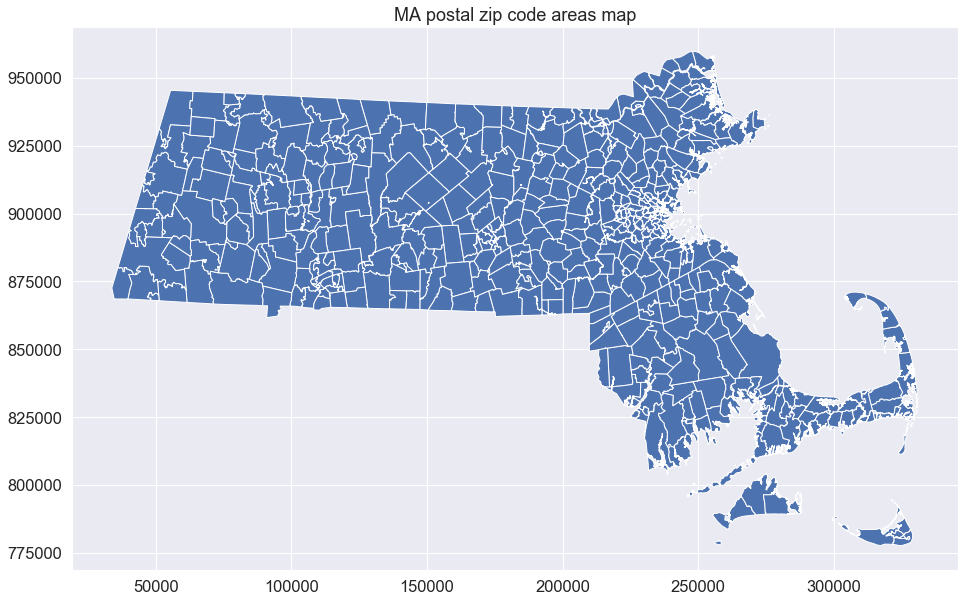

In [24]:
ma_postzip_map.plot(figsize=(16,10))
plt.title('MA postal zip code areas map')
plt.show()

In [25]:
print(len(set(ma_postzip_map['CITY_TOWN'])))
print(len(set(ma_postzip_map['PC_NAME'])))

335
458


In [52]:
# fix the city_town column - this looks to be what I might be looking for
ma_postzip_map['CITY_TOWN'] = ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')

In [54]:
# mismatches - what's in the postal map that's not in the opioid overdose dataset?:
set(ma_postzip_map['CITY_TOWN']) - set(ma_over_death['city_death'])

{'charlemont',
 'manchester by the sea',
 'monroe',
 'mt washington',
 'worthington'}

In [55]:
# what's in the opioid overdose dataset that's not in the postal map?
set(ma_over_death['city_death']) - set(ma_postzip_map['CITY_TOWN'])

{'alford',
 'aquinnah',
 'clarksburg',
 'granville',
 'hawley',
 'leyden',
 'manchester',
 'montgomery',
 'mount washington',
 'new ashford',
 'pelham',
 'peru',
 'phillipston',
 'tisbury',
 'washington',
 'west tisbury',
 'westhampton'}

Much more manageable, few fixes

* manchester and manchester by the sea seem to be the same town (wikipedia)
* mt washington and mount washington - different spelling
* charlemont was one of the towns without a census block association (notebook 3)

In [56]:
ma_over_death['city_death_match'] = ma_over_death['city_death'].str.replace('manchester', 'manchester by the sea').str.replace('mount washington', 'mt washington')

In [57]:
# death counts for towns/cities I'm missing
ma_over_death[ma_over_death['city_death_match'].isin(set(ma_over_death['city_death_match']) - set(ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')))]

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,...,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status,city_death_match
5,alford,0,0,0,0,0,458.428571,446.571429,434.714286,422.857143,...,219,0.532847,105625.00,148519.270833,1.453488,0.048662,0.024331,rural,shrunk,alford
9,aquinnah,0,0,0,0,0,452.000000,499.000000,546.000000,593.000000,...,66,0.103125,80250.00,103304.316547,9.667674,0.217188,0.050000,rural,grown,aquinnah
62,clarksburg,0,0,0,1,0,1710.571429,1713.428571,1716.285714,1719.142857,...,494,0.286876,60558.00,72516.151094,7.096774,0.095404,0.132635,rural,uncertain,clarksburg
109,granville,0,0,0,0,0,1606.285714,1619.714286,1633.142857,1646.571429,...,302,0.181928,86000.00,93351.480263,4.056291,0.083942,0.065693,rural,grown,granville
126,hawley,0,0,0,0,0,930.857143,942.142857,953.428571,964.714286,...,267,0.273566,59167.00,71880.150754,9.433962,0.118191,0.157246,rural,grown,hawley
153,leyden,0,0,0,0,0,1809.571429,1805.428571,1801.285714,1797.142857,...,443,0.247072,65588.00,81706.330749,5.201465,0.114607,0.112921,rural,uncertain,leyden
190,montgomery,0,0,0,0,0,822.571429,817.428571,812.285714,807.142857,...,148,0.184539,74000.00,91171.739130,3.398058,0.037406,0.087282,rural,uncertain,montgomery
196,new ashford,0,0,0,0,0,273.428571,288.571429,303.714286,318.857143,...,81,0.242515,84583.00,92367.213115,7.053942,0.078788,0.042424,rural,grown,new ashford
226,pelham,0,0,0,0,0,1302.142857,1295.857143,1289.571429,1283.285714,...,343,0.268598,92250.00,116789.122137,2.277433,0.040031,0.032967,rural,uncertain,pelham
229,peru,0,0,0,1,0,831.571429,826.428571,821.285714,816.142857,...,115,0.141800,68636.00,77355.714286,8.307210,0.067818,0.108508,rural,uncertain,peru


These are pretty small towns - for some, it looks like they're considered to be a part of other towns? 

Have to keep moving on, afraid will have to lose them

In [60]:
# how many zipcodes in prescriber dataset not in the postal map?
print(len(set(opi_pres_17_MA['nppes_provider_zip_code']) - set(ma_postzip_map['POSTCODE'])))
# other way around?
print(len(set(ma_postzip_map['POSTCODE']) - set(opi_pres_17_MA['nppes_provider_zip_code'])))

74
105


In [66]:
# try to fix mismatches - how many prescribers are associated with zip codes not in the postal map shapefile?
zip_miss = set(opi_pres_17_MA['nppes_provider_zip_code']) - set(ma_postzip_map['POSTCODE'])
# total number of unique npi in 2017 MA opioid prescriber dataset:
print(len(set(opi_pres_17_MA['npi'])))
# number missing from the postal zip codes map
print(len(set(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(zip_miss)]['npi'])))

35730
2316


In [65]:
opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(zip_miss)]

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
303,1003015686,BLUME,DEBORAH,01199,MA,Physician Assistant,1562,28.0,1.79,0.0,0.0
769,1003041971,IRONS,HILLARY,01655,MA,Emergency Medicine,53,NaN,NaN,0.0,NaN
1516,1003080151,NICORA,AGNIESZKA,01199,MA,Emergency Medicine,216,NaN,NaN,0.0,NaN
1662,1003090143,DUBIN,JOSEPH,01805,MA,Internal Medicine,139,NaN,NaN,0.0,NaN
1995,1003108259,KORAPATI,SOWMYA,01655,MA,Hematology-Oncology,15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1159959,1992854707,ABRAMOV,KONSTANTIN,01655,MA,Nephrology,1519,27.0,1.78,NaN,NaN
1160834,1992891352,DEPETERS,FRANKLIN,01655,MA,Diagnostic Radiology,68,0.0,0.00,0.0,NaN
1161153,1992902977,CROWLEY,JILLIAN,01199,MA,Physician Assistant,107,18.0,16.82,0.0,0.0
1162263,1992964183,MACLACHLAN,LARA,01805,MA,Urology,1487,NaN,NaN,0.0,NaN


In [69]:
# subset map to try and match up zip codes and towns
postzip_town_match = ma_postzip_map.iloc[:, 0:7]
display(postzip_town_match.head())

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,athol,WORCESTER
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,westfield,HAMPDEN
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,shelburne,FRANKLIN
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,hinsdale,BERKSHIRE
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,dartmouth,BRISTOL


In [71]:
# PC and PA name columns look identical - are they?
print(sum(postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']))
display(postzip_town_match[postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']])
postzip_town_match = postzip_town_match.apply(lambda x: x.str.lower())
postzip_town_match.head()

3


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
497,01441,TYCO,UNIQUE ORGANIZATION,WESTMINSTER,76975,westminster,WORCESTER
520,02357,STONEHILL COLLEGE,UNIQUE ORGANIZATION,NORTH EASTON,47625,easton,BRISTOL
530,01063,SMITH COLLEGE,UNIQUE ORGANIZATION,NORTHAMPTON,46330,northampton,HAMPSHIRE


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
0,01331,athol,non unique,athol,02515,athol,worcester
1,01085,westfield,non unique,westfield,76030,westfield,hampden
2,01370,shelburne falls,non unique,shelburne falls,61205,shelburne,franklin
3,01235,hinsdale,non unique,hinsdale,30280,hinsdale,berkshire
4,02747,north dartmouth,non unique,north dartmouth,47450,dartmouth,bristol


In [72]:
print(set(ma_over_death['city_death_match']) - set(postzip_town_match['CITY_TOWN']))
print(set(postzip_town_match['CITY_TOWN']) - set(ma_over_death['city_death_match']))

{'aquinnah', 'west tisbury', 'pelham', 'leyden', 'new ashford', 'peru', 'clarksburg', 'granville', 'phillipston', 'washington', 'montgomery', 'alford', 'westhampton', 'tisbury', 'hawley'}
{'worthington', 'charlemont', 'monroe'}


In [73]:
len(zip_miss)

74

Maybe the zip code - town association files will be useful for filling in these missing town - zip code associations that do match the opioid overdose death dataset?

In [75]:
print(len(set(ma_over_death['city_death_match']) - set(zip_town['town'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_raw_alt['city'].str.lower())))
#zip_town town names are more similar to the opioid overdose death count towns - try that one

4
28


In [76]:
print(len(zip_miss))
print(len(zip_town[zip_town['zip'].isin(zip_miss)]))

74
36


In [77]:
zip_fill = zip_town[zip_town['zip'].isin(zip_miss) & zip_town['town'].isin(set(ma_over_death['city_death']))]
zip_fill

,zip,town
88,02117,boston
111,02199,boston
118,02211,boston
124,02241,boston
143,02185,braintree
148,02325,bridgewater
167,01805,burlington
177,02238,cambridge
298,02334,easton
309,02722,fall river


In [78]:
zip_town_fin = postzip_town_match[['POSTCODE', 'CITY_TOWN']]
zip_town_fin.columns = list(zip_fill.columns)
zip_town_fin = pd.concat([zip_town_fin, zip_fill]).reindex()
print(zip_town_fin.shape)
print(zip_town_fin.drop_duplicates().shape)
zip_town_fin.head()

(572, 2)
(572, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [82]:
print(len(set(zip_town_fin['town']) - set(ma_over_death['city_death_match'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_fin['town'])))
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))
# getting closer

3
13
{'worthington', 'charlemont', 'monroe'}
{'aquinnah', 'pelham', 'leyden', 'new ashford', 'peru', 'clarksburg', 'granville', 'phillipston', 'washington', 'montgomery', 'alford', 'westhampton', 'hawley'}


In [86]:
# zip codes that have a town association - but that town name is not in the opioid overdose death data 
# do these zip codes have another association that matches the opioid overdose death data?
zip_miss_town = zip_town[zip_town['zip'].isin(zip_miss) & ~zip_town['town'].isin(set(ma_over_death['city_death']))].copy()
display(zip_miss_town)
# used manual database look up to look these up
zip_miss_town['alt_town'] = ['springfield', 'bridgewater', 'orleans',
                   'boston', 'cambridge', 'danvers',
                   'burlington', 'plymouth', 'marshfield',
                   'eastham', 'northampton', 'winchendon', 'winchendon']
zip_miss_town

,zip,town
54,01199,baystate medical
149,02325,bridgewater state college
282,02643,east orleans
323,02241,fleet bank boston
383,02238,harvard square
391,01937,hathorne
445,01805,lahey clinic medical center
498,02345,manomet
509,02051,marshfield hills
651,02651,north eastham


,zip,town,alt_town
54,01199,baystate medical,springfield
149,02325,bridgewater state college,bridgewater
282,02643,east orleans,orleans
323,02241,fleet bank boston,boston
383,02238,harvard square,cambridge
391,01937,hathorne,danvers
445,01805,lahey clinic medical center,burlington
498,02345,manomet,plymouth
509,02051,marshfield hills,marshfield
651,02651,north eastham,eastham


In [87]:
# are all of these new alternative town names in the opioid overdose death dataset?
set(zip_miss_town['alt_town']) - set(ma_over_death['city_death_match'])
# yes

set()

In [88]:
display(zip_town_fin)
# modify to combine these two dfs
zip_miss_town = zip_miss_town.drop('town', axis=1)
zip_miss_town.columns = zip_town_fin.columns

,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth
...,...,...
892,01199,springfield
923,02575,tisbury
1015,02575,west tisbury
1082,01614,worcester


In [89]:
zip_town_fin = pd.concat([zip_town_fin, zip_miss_town]).drop_duplicates()
print(zip_town_fin.shape)
zip_town_fin.head()

(578, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [91]:
print(len(set(zip_town_fin['town']) - set(ma_over_death['city_death_match'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_fin['town'])))
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))

3
13
{'worthington', 'charlemont', 'monroe'}
{'aquinnah', 'pelham', 'leyden', 'new ashford', 'peru', 'clarksburg', 'granville', 'phillipston', 'washington', 'montgomery', 'alford', 'westhampton', 'hawley'}


In [92]:
# how many zip codes associated with more than 1 town?
zip_town_counts = zip_town_fin['zip'].value_counts().reset_index()
zip_town_counts.columns = ['zip', 'count']
print(zip_town_counts[zip_town_counts['count'] > 1].shape)
zip_town_counts[zip_town_counts['count'] > 1]

(23, 2)


,zip,count
0,02467,3
1,01082,3
2,01050,2
3,02135,2
4,01026,2
5,02532,2
6,02136,2
7,02575,2
8,01247,2
9,02151,2


In [95]:
# number of opi prescribers now missing with this better zip code - town association list:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(opi_pres_17_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)
# down from 2k + missing to only 52 - great!

(52, 11)


### Step 2: Associate all opioid prescribers with opioid overdose death town name (join by zip code) and 2017 all-drug prescribers with zip code (based on npi from opioid prescriber dataset) and then with town (based on zip code)

* how many all-drug prescribers don't have an associated town?
* check for duplicate town assignments to prescribers

In [96]:
# give the all drug prescribers zipcodes
all_pres_17_MA_prov = all_pres_17_MA_prov.merge(opi_pres_17_MA[['npi', 'nppes_provider_zip_code']], on='npi', how='left')
display(all_pres_17_MA_prov.info())
display(all_pres_17_MA_prov.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27300 entries, 0 to 27299
Data columns (total 7 columns):
npi                             27300 non-null int64
nppes_provider_last_org_name    27299 non-null object
nppes_provider_first_name       27300 non-null object
nppes_provider_city             27300 non-null object
nppes_provider_state            27300 non-null object
specialty_description           27300 non-null object
nppes_provider_zip_code         27300 non-null object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


None

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,nppes_provider_zip_code
0,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,02169
1,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,01609
2,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology,02115
3,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,02114
4,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist,02445


In [98]:
# number of all drug prescribers missing/being dropped because of zip code:
print(len(set(all_pres_17_MA_prov['npi'])))
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(all_pres_17_MA_prov['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)
# only 41 - great

27300
(41, 7)


In [100]:
opi_pres_17_MA['nppes_provider_last_name'] = opi_pres_17_MA['nppes_provider_last_name'].str.lower()
opi_pres_17_MA['nppes_provider_first_name'] = opi_pres_17_MA['nppes_provider_first_name'].str.lower()
opi_pres_17_MA['specialty_description'] = opi_pres_17_MA['specialty_description'].str.lower()
print(opi_pres_17_MA.shape)
opi_pres_17_town = opi_pres_17_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_17_town.shape)
opi_pres_17_town.head()

(35730, 11)
(37069, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4487,513.0,11.43,84.0,16.37,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,1363,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,905,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1133,NaN,NaN,NaN,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,54,NaN,NaN,0.0,NaN,02169,quincy


In [101]:
# number of opi prescribers w/more than 1 town association:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)
# number of all drug prescribers w/more than 1 town association:
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)

(1156, 11)
(876, 7)


In [102]:
opi_pres_17_cols = list(opi_pres_17_town.columns)
# reoder columns and drop extra zipcode col that appeared because of merge
opi_pres_17_town = opi_pres_17_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_17_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,rheumatology,4487,513.0,11.43,84.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,1363,0.0,0.00,0.0
2,1003291121,blair,meghan,02169,quincy,MA,nurse practitioner,905,0.0,0.00,0.0
3,1003834433,nair,anil,02169,quincy,MA,neurology,1133,NaN,NaN,NaN
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,54,NaN,NaN,0.0


In [103]:
npi_town_count = opi_pres_17_town['npi'].value_counts().reset_index()
npi_town_count.columns = ['npi', 'count']
display(npi_town_count.head())
npi_town_count[npi_town_count['count'] > 1].shape

,npi,count
0,1962471714,3
1,1689687097,3
2,1679530083,3
3,1720064272,3
4,1306882410,3


(1156, 2)

Will need to deal with duplicates at some point - not sure why this is happening (dealt with notebook 6 actually)

Clean up other opioid prescriber datasets (filter for MA only, lower case string, etc - associate with town):

In [105]:
# other opioid dataset processing:
opi_pres_13_MA = opi_pres_13_raw[opi_pres_13_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_14_MA = opi_pres_14_raw[opi_pres_14_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_15_MA = opi_pres_15_raw[opi_pres_15_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_16_MA = opi_pres_16_raw[opi_pres_16_raw['nppes_provider_state'] == 'MA'].copy()

In [106]:
# zip code fix for all files
MA_opi_dflist = [opi_pres_13_MA, opi_pres_14_MA, opi_pres_15_MA, opi_pres_16_MA]
for x in MA_opi_dflist:
    x['nppes_provider_zip_code'] = [x.zfill(5) for x in list(x['nppes_provider_zip_code'].astype(int).astype(str))]

In [107]:
# lowercase names
for x in MA_opi_dflist:
    x['nppes_provider_last_name'] = x['nppes_provider_last_name'].str.lower()
for x in MA_opi_dflist:
    x['nppes_provider_first_name'] = x['nppes_provider_first_name'].str.lower()
for x in MA_opi_dflist:
    x['specialty_description'] = x['specialty_description'].str.lower()

In [108]:
# how many providers missing from the zip code -town association df for each of these?
print(len(set(opi_pres_13_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_14_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_15_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_16_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))

53
46
49
46


Looks like the vast majority of the opioid prescribers are in the zip code - town association dataset - good news.

Perform zip code - town merges, check if each went as expected:

In [110]:
print(opi_pres_13_MA.shape)
opi_pres_13_town = opi_pres_13_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_13_town.shape)
opi_pres_13_town.head()
# also duplicates here

(32791, 11)
(34086, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4139,522.0,12.61,104.0,19.92,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,40,0.0,0.00,0.0,NaN,02169,quincy
2,1003834433,nair,anil,02169,MA,neurology,1217,NaN,NaN,NaN,NaN,02169,quincy
3,1003895269,angelini,domenic,02169,MA,dentist,14,0.0,0.00,0.0,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,37,NaN,NaN,0.0,NaN,02169,quincy


In [111]:
print(opi_pres_14_MA.shape)
opi_pres_14_town = opi_pres_14_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_14_town.shape)
opi_pres_14_town.head()

(33380, 11)
(34734, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003001660,newton,robert,02446,MA,urology,12,0.0,0.0,0.0,NaN,02446,brookline
1,1003841198,kaplan,mark,02446,MA,obstetrics/gynecology,76,0.0,0.0,0.0,NaN,02446,brookline
2,1003842543,"reiner,jr",marshall,02446,MA,pediatric medicine,45,NaN,NaN,0.0,NaN,02446,brookline
3,1013101740,lee,peter,02446,MA,dentist,30,0.0,0.0,0.0,NaN,02446,brookline
4,1013125731,lipetsker,nickolay,02446,MA,dentist,134,0.0,0.0,0.0,NaN,02446,brookline


In [112]:
print(opi_pres_15_MA.shape)
opi_pres_15_town = opi_pres_15_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_15_town.shape)
opi_pres_15_town.head()

(34081, 11)
(35416, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4183,495.0,11.83,99.0,20.0,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,906,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,45,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1079,16.0,1.48,0.0,0.0,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,17,NaN,NaN,0.0,NaN,02169,quincy


In [113]:
print(opi_pres_16_MA.shape)
opi_pres_16_town = opi_pres_16_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_16_town.shape)
opi_pres_16_town.head()

(35029, 11)
(36357, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4634,593.0,12.80,106.0,17.88,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiovascular disease (cardiology),1147,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,888,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1096,14.0,1.28,0.0,0.00,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,26,0.0,0.00,0.0,NaN,02169,quincy


In [114]:
print(list(opi_pres_13_town.columns) == opi_pres_17_cols)
#opi_town_dflist = [opi_pres_13_town, opi_pres_14_town, opi_pres_15_town, opi_pres_16_town]
#for x in opi_town_dflist:
#    x = x[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

True


In [115]:
opi_pres_13_town = opi_pres_13_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_14_town = opi_pres_14_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_15_town = opi_pres_15_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_16_town = opi_pres_16_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

In [117]:
opi_pres_13_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,internal medicine,4139,522.0,12.61,104.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,40,0.0,0.00,0.0
2,1003834433,nair,anil,02169,quincy,MA,neurology,1217,NaN,NaN,NaN
3,1003895269,angelini,domenic,02169,quincy,MA,dentist,14,0.0,0.00,0.0
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,37,NaN,NaN,0.0


In [118]:
# does dropping duplicates do anything at all?
print(opi_pres_13_town.shape)
print(opi_pres_13_town.drop_duplicates().shape)
print(opi_pres_14_town.shape)
print(opi_pres_14_town.drop_duplicates().shape)
print(opi_pres_15_town.shape)
print(opi_pres_15_town.drop_duplicates().shape)
print(opi_pres_16_town.shape)
print(opi_pres_16_town.drop_duplicates().shape)
print(opi_pres_17_town.shape)
print(opi_pres_17_town.drop_duplicates().shape)
# nope

(34086, 11)
(34086, 11)
(34734, 11)
(34734, 11)
(35416, 11)
(35416, 11)
(36357, 11)
(36357, 11)
(37069, 11)
(37069, 11)


In [120]:
# create year column for each df
opi_pres_13_town['year'] = ['2013'] * len(opi_pres_13_town.index)
opi_pres_14_town['year'] = ['2014'] * len(opi_pres_14_town.index)
opi_pres_15_town['year'] = ['2015'] * len(opi_pres_15_town.index)
opi_pres_16_town['year'] = ['2016'] * len(opi_pres_16_town.index)
opi_pres_17_town['year'] = ['2017'] * len(opi_pres_17_town.index)

In [121]:
opi_pres_17_town.sample(20)

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
36641,1548210206,mase,jeanne,02536,falmouth,MA,family practice,3194,381.0,11.93,107.0,2017
9259,1427087881,cetrulo,curtis,02111,boston,MA,obstetrics & gynecology,26,0.0,0.00,0.0,2017
35033,1053520551,kozlauska,john,01940,lynnfield,MA,dentist,22,NaN,NaN,0.0,2017
28888,1073567749,khajavi-noori,farrokh,02180,stoneham,MA,psychiatry,2107,0.0,0.00,0.0,2017
6074,1417128596,qadir,muhammad,02649,mashpee,MA,family practice,1020,96.0,9.41,34.0,2017
8837,1801856877,weston,susan,01230,great barrington,MA,psychiatry,1882,0.0,0.00,0.0,2017
27258,1346575289,kilroy,jeffrey,01950,newburyport,MA,nurse practitioner,2501,55.0,2.20,NaN,2017
13856,1033269600,groteguth,scot,01805,burlington,MA,internal medicine,24,0.0,0.00,0.0,2017
17238,1427222595,petrulio,christian,02740,new bedford,MA,orthopedic surgery,276,190.0,68.84,0.0,2017
18535,1528015468,tannebring,charles,01915,beverly,MA,dentist,14,0.0,0.00,0.0,2017


Write result to csv - but will have to edit these to remove multiple prescriber - town associations

In [124]:
#opi_pres_13_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv", index=False)
#opi_pres_14_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv", index=False)
#opi_pres_15_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv", index=False)
#opi_pres_16_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv", index=False)
#opi_pres_17_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv", index=False)

### Step 3: All drug MA prescribers

This section was modified to rely on the zip code - town associations derived from notebook 6, where the issue of opioid prescribers being linked to more than 1 town was dealt with.

In [ ]:
all_pres_17_MA_prov.head()

In [ ]:
med_opi_pres_no_town_dup = pd.read_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv")
med_opi_pres_no_town_dup.head()

In [ ]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup['npi'])))
print(len(set(all_pres_17_MA['npi'])))

In [ ]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017]['npi'])))

In [ ]:
all_pres_17_MA_prov = all_pres_17_MA_prov.drop('nppes_provider_zip_code', axis=1).apply(lambda x: x.astype(str).str.lower())


In [ ]:
all_pres_17_MA_prov['npi'] = all_pres_17_MA_prov['npi'].astype(int)

In [ ]:
len(set(all_pres_17_MA_prov['npi']) - set(med_opi_pres_no_town_dup['npi']))

In [ ]:
all_pres_17_prov = all_pres_17_MA_prov.drop(['nppes_provider_city', 'nppes_provider_state', 'specialty_description'], axis=1)
print(all_pres_17_prov.shape)
print(all_pres_17_prov.drop_duplicates().shape)
all_pres_17_prov.head()

In [ ]:
print(len(set(all_pres_17_MA_prov['npi'])))
print(len(all_pres_17_MA_prov[['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name']].index))
print(len(all_pres_17_MA_prov[['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name']].index))

In [ ]:
med_opi_pres_no_town_dup.head()

In [ ]:
opi_pres_17_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
opi_pres_17_npi_town_match.head()

In [ ]:
all_pres_17_MA.head()

Drug ideas source:
https://mhc.cpnp.org/doi/full/10.9740/mhc.2016.05.120

In [ ]:
alprazolam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]

In [ ]:
print(alprazolam_17_pres.shape)
alprazolam_17_pres.head()

In [ ]:
alprazolam_17_pres['drug_name'].value_counts()

In [ ]:
diazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_17_pres.shape)
diazepam_17_pres.head()

In [ ]:
diazepam_17_pres['drug_name'].value_counts()

In [ ]:
lorazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_17_pres.shape)
lorazepam_17_pres.head()

In [ ]:
lorazepam_17_pres['drug_name'].value_counts()

In [ ]:
benzo_pres_17 = pd.concat([alprazolam_17_pres, diazepam_17_pres, lorazepam_17_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
benzo_pres_17.head()

In [ ]:
benzo_pres_17.info()

In [ ]:
# drop cols with a lot of NA
benzo_pres_17_sub = benzo_pres_17.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_17_sub.shape)
benzo_pres_17_sub.head()

In [ ]:
for x in list(benzo_pres_17_sub.columns)[1:6]:
    benzo_pres_17_sub[x] = benzo_pres_17_sub[x].str.lower()

In [ ]:
benzo_pres_17_sub.head()

In [ ]:
opi_pres_17_npi_town_match.head()

In [ ]:
print(benzo_pres_17_sub.shape)
print(opi_pres_17_npi_town_match.shape)
benzo_town_merge = benzo_pres_17_sub.merge(opi_pres_17_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge.shape)
print(benzo_town_merge.columns)
benzo_town_merge.head()

In [ ]:
# merge checks
print(sum(benzo_town_merge['nppes_provider_last_org_name'] != benzo_town_merge['nppes_provider_last_name']))
print(sum(benzo_town_merge['nppes_provider_first_name_benz'] != benzo_town_merge['nppes_provider_first_name_opi']))
benzo_town_merge.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

In [ ]:
benzo_town_merge_17 = benzo_town_merge.copy()

In [ ]:
#benzo_town_merge.to_csv("../../data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge.csv", index=False)

In [ ]:
benzo_town_merge.head()

In [ ]:
benzo_town_merge.drop(['nppes_provider_last_org_name', 'nppes_provider_first_name_benz'], axis=1, inplace=True)

In [ ]:
benzo_town_merge.head()

In [ ]:
benzo_town_sum = benzo_town_merge.groupby(['town', 'generic_name']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_sum.shape)
benzo_town_sum.head()

In [ ]:
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'])

In [ ]:
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'].iloc[:, 2:].apply(np.sqrt))

In [ ]:
benzo_town_sum_norm = benzo_town_sum.copy()
for x in list(benzo_town_sum_norm.columns)[2:]:
    benzo_town_sum_norm[x] = np.sqrt(benzo_town_sum_norm[x])
benzo_town_sum_norm.head()

In [ ]:
sns.pairplot(benzo_town_sum_norm, hue="generic_name")

## Clean older prescriber data

In [ ]:
#cms_all_pres_raw = pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_17.txt", sep='\t')
del cms_all_pres_raw

In [ ]:
cms_all_pres_16_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_16.txt", sep='\t')

In [ ]:
cms_all_pres_16_raw.columns

In [ ]:
all_pres_16_MA = cms_all_pres_16_raw[cms_all_pres_16_raw['nppes_provider_state'] == 'MA']
all_pres_16_MA.head()

In [ ]:
alprazolam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_16_pres.shape)
display(alprazolam_16_pres['drug_name'].value_counts())
diazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_16_pres.shape)
display(diazepam_16_pres['drug_name'].value_counts())
lorazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_16_pres.shape)
display(lorazepam_16_pres['drug_name'].value_counts())

In [ ]:
benzo_pres_16 = pd.concat([alprazolam_16_pres, diazepam_16_pres, lorazepam_16_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_16.head())
display(benzo_pres_16.info())

In [ ]:
benzo_pres_16_sub = benzo_pres_16.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_16_sub.shape)
benzo_pres_16_sub.head()

In [ ]:
for x in list(benzo_pres_16_sub.columns)[1:6]:
    benzo_pres_16_sub[x] = benzo_pres_16_sub[x].str.lower()

In [ ]:
opi_pres_16_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2016][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_16_sub.shape)
print(opi_pres_16_npi_town_match.shape)
benzo_town_merge_16 = benzo_pres_16_sub.merge(opi_pres_16_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_16.shape)
print(benzo_town_merge_16.columns)
benzo_town_merge_16.head()

In [ ]:
print(sum(benzo_town_merge_16['nppes_provider_last_org_name'] != benzo_town_merge_16['nppes_provider_last_name']))
print(sum(benzo_town_merge_16['nppes_provider_first_name_benz'] != benzo_town_merge_16['nppes_provider_first_name_opi']))
benzo_town_merge_16.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

In [ ]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
display(benzo_town_merge_17.head())
display(benzo_town_merge_16.head())

In [ ]:
del cms_all_pres_16_raw

In [ ]:
cms_all_pres_15_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_15.txt", sep='\t')

In [ ]:
all_pres_15_MA = cms_all_pres_15_raw[cms_all_pres_15_raw['nppes_provider_state'] == 'MA']
alprazolam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_15_pres.shape)
display(alprazolam_15_pres['drug_name'].value_counts())
diazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_15_pres.shape)
display(diazepam_15_pres['drug_name'].value_counts())
lorazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_15_pres.shape)
display(lorazepam_15_pres['drug_name'].value_counts())

In [ ]:
benzo_pres_15 = pd.concat([alprazolam_15_pres, diazepam_15_pres, lorazepam_15_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_15.info())

In [ ]:
benzo_pres_15_sub = benzo_pres_15.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_15_sub.shape)
benzo_pres_15_sub.head()

In [ ]:
for x in list(benzo_pres_15_sub.columns)[1:6]:
    benzo_pres_15_sub[x] = benzo_pres_15_sub[x].str.lower()

In [ ]:
opi_pres_15_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2015][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_15_sub.shape)
print(opi_pres_15_npi_town_match.shape)
benzo_town_merge_15 = benzo_pres_15_sub.merge(opi_pres_15_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_15.shape)
print(benzo_town_merge_15.columns)
benzo_town_merge_15.head()

In [ ]:
print(sum(benzo_town_merge_15['nppes_provider_last_org_name'] != benzo_town_merge_15['nppes_provider_last_name']))
print(sum(benzo_town_merge_15['nppes_provider_first_name_benz'] != benzo_town_merge_15['nppes_provider_first_name_opi']))
benzo_town_merge_15.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

In [ ]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)

In [ ]:
del cms_all_pres_15_raw

In [ ]:
cms_all_pres_14_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_14.txt", sep='\t')

In [ ]:
all_pres_14_MA = cms_all_pres_14_raw[cms_all_pres_14_raw['nppes_provider_state'] == 'MA']
alprazolam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_14_pres.shape)
display(alprazolam_14_pres['drug_name'].value_counts())
diazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_14_pres.shape)
display(diazepam_14_pres['drug_name'].value_counts())
lorazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_14_pres.shape)
display(lorazepam_14_pres['drug_name'].value_counts())

In [ ]:
benzo_pres_14 = pd.concat([alprazolam_14_pres, diazepam_14_pres, lorazepam_14_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_14.info())

In [ ]:
benzo_pres_14_sub = benzo_pres_14.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_14_sub.shape)
benzo_pres_14_sub.head()

In [ ]:
for x in list(benzo_pres_14_sub.columns)[1:6]:
    benzo_pres_14_sub[x] = benzo_pres_14_sub[x].str.lower()

In [ ]:
opi_pres_14_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2014][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_14_sub.shape)
print(opi_pres_14_npi_town_match.shape)
benzo_town_merge_14 = benzo_pres_14_sub.merge(opi_pres_14_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_14.shape)
print(benzo_town_merge_14.columns)
benzo_town_merge_14.head()

In [ ]:
print(sum(benzo_town_merge_14['nppes_provider_last_org_name'] != benzo_town_merge_14['nppes_provider_last_name']))
print(sum(benzo_town_merge_14['nppes_provider_first_name_benz'] != benzo_town_merge_14['nppes_provider_first_name_opi']))
benzo_town_merge_14.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

In [ ]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)

In [ ]:
del cms_all_pres_14_raw

In [ ]:
cms_all_pres_13_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_13.txt", sep='\t')

In [ ]:
all_pres_13_MA = cms_all_pres_13_raw[cms_all_pres_13_raw['nppes_provider_state'] == 'MA']
alprazolam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_13_pres.shape)
display(alprazolam_13_pres['drug_name'].value_counts())
diazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_13_pres.shape)
display(diazepam_13_pres['drug_name'].value_counts())
lorazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_13_pres.shape)
display(lorazepam_13_pres['drug_name'].value_counts())

In [ ]:
benzo_pres_13 = pd.concat([alprazolam_13_pres, diazepam_13_pres, lorazepam_13_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_13.info())

In [ ]:
benzo_pres_13_sub = benzo_pres_13.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_13_sub.shape)
benzo_pres_13_sub.head()

In [ ]:
for x in list(benzo_pres_13_sub.columns)[1:6]:
    benzo_pres_13_sub[x] = benzo_pres_13_sub[x].str.lower()

In [ ]:
opi_pres_13_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2013][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_13_sub.shape)
print(opi_pres_13_npi_town_match.shape)
benzo_town_merge_13 = benzo_pres_13_sub.merge(opi_pres_13_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_13.shape)
print(benzo_town_merge_13.columns)
benzo_town_merge_13.head()

In [ ]:
print(sum(benzo_town_merge_13['nppes_provider_last_org_name'] != benzo_town_merge_13['nppes_provider_last_name']))
print(sum(benzo_town_merge_13['nppes_provider_first_name_benz'] != benzo_town_merge_13['nppes_provider_first_name_opi']))
benzo_town_merge_13.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

In [ ]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)
print(benzo_town_merge_13.shape)

In [ ]:
benzo_town_merge_17['year'] = 2017
benzo_town_merge_16['year'] = 2016
benzo_town_merge_15['year'] = 2015
benzo_town_merge_14['year'] = 2014
benzo_town_merge_13['year'] = 2013

In [ ]:
benzo_pres_town_all = pd.concat([benzo_town_merge_17, benzo_town_merge_16, benzo_town_merge_15, benzo_town_merge_14, benzo_town_merge_13])
print(benzo_pres_town_all.shape)
display(benzo_pres_town_all.head())
sum(benzo_pres_town_all[['npi', 'year']].drop_duplicates()['npi'].value_counts() > 5)

In [ ]:
#benzo_pres_town_all.to_csv("../../data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge_13_to_17.csv", index=False)

In [ ]:
benzo_town_year_sum = benzo_pres_town_all.groupby(['town', 'generic_name', 'year']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_year_sum.shape)
benzo_town_year_sum.head()

In [ ]:
#benzo_town_year_sum.to_csv("../../data/tidy_data/med_partD_benzo_sum_w_town_merge_13_to_17.csv", index=False)